In [1]:
import os
import json
import gc

import torch 
import torch.nn.functional as F
from transformers import AutoModelForCausalLM,  StoppingCriteria, StoppingCriteriaList, AutoTokenizer,BitsAndBytesConfig, pipeline, AutoConfig , TrainingArguments, AutoModelForCausalLM, BitsAndBytesConfig
import trl
from trl import apply_chat_template
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, PeftConfig


from tqdm import tqdm_notebook
from datasets import Dataset

import bitsandbytes as bnb

In [ ]:
def load_dataset(path):
    with open(path,'r') as f:
        dataset =  json.load(f)
    return dataset

def get_embedding(model, tokenizer, text: str, aggregation_method: str = None):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    last_hidden_state = outputs.hidden_states[-1]

    if aggregation_method == 'mean':
        # Mean pool the token embeddings to get a sentence embedding
        embedding = last_hidden_state.mean(dim=1)
    elif aggregation_method == 'last_token':
        # Get the hidden state of the last token
        embedding = last_hidden_state[:, -1, :]  # Shape: [batch_size, hidden_size]
    else:
        # If no valid aggregation method is specified, return the last hidden state
        embedding = last_hidden_state

    # Normalize the embedding (if applicable)
    if aggregation_method in ['mean', 'last_token']:
        embedding = F.normalize(embedding, p=2, dim=1)

    return embedding

def construct_statement_annotation_pair(dataset_input):
    statement_annotation_pair = {}
    for i,document in enumerate(dataset_input):
        #print(document['id'])
        statement_annotation_pair[i] = {}
        statement_annotation_pair[i]['statement'] = ''
        for idx,span in enumerate(document['spans']):
            #print(span)
            statement_annotation_pair[i]['statement'] += f'''[[statement_id_{idx}]]: {document['text'][span[0]:span[1]]}\n'''
            statement_annotation_pair[i]['target'] =  document['annotation_sets'][0]
    return statement_annotation_pair


def prepare_dataset_for_finetuning_method1(train_contract_statements_and_annotations,hypothesis_set,tokeniser,max_tokens=8192):
    '''
    {
        "prompt": [{"role": "user", "content": "What color is the sky?"}],
        "completion": [{"role": "assistant", "content": "It is blue."}]
    }
    '''
    dataset = []
    total_points = 0
    skipped_points = 0
    for idx,contract in tqdm_notebook(train_contract_statements_and_annotations.items()):
        #current_system_prompt = ft_system_prompt.format(contract['statement'])
        for key,value in hypothesis_set.items():
            #current_user_prompt = f"Evaluate following hypothesis: \n{value['hypothesis']}"
            data_point = {
                "doc_id": idx,
                "prompt": [
                    {
                        "role": "system",
                        "content": ft_system_prompt
                    },
                    {
                        "role": "user",
                        "content": ft_user_prompt.format(contract['statement'],value['hypothesis'])
                    }
                ],
                "completion": [
                    {
                        "role": "assistant",
                        "content": f"```json\n{json.dumps(contract['target']['annotations'][key])}\n```"
                    }
                ]
            }
            chatified_text = apply_chat_template(data_point,tokeniser)
            prompt_tokens = len(tokeniser(chatified_text['prompt'],truncation=False)['input_ids'])
            completion_tokens = len(tokeniser(chatified_text['completion'],truncation=False)['input_ids'])
            total_points += 1
            if(prompt_tokens  + completion_tokens <= max_tokens):
                dataset.append(apply_chat_template(data_point,tokeniser))
            else:
                skipped_points += 1

    return Dataset.from_list(dataset),total_points,skipped_points

'''
With All Statements
'''
def generate_message_target_pair(idx,train_contract_statements_and_annotations,nda,model=None,tokeniser=None):
    sim_scores = {}
    example_data = train_contract_statements_and_annotations[idx]
    current_system_prompt = system_prompt.format(example_data['statement'])
    hypothesis_embed = get_embedding(model,tokeniser,hypothesis_set[nda]['hypothesis'],'mean')
    if model is not None and tokeniser is not None:
        for idx,statement in enumerate(example_data['statement'].split('\n')):
            if len(statement) > 0:
                statement_embed = get_embedding(model,tokeniser,statement,'mean')
                sim_scores[statement.split(']]')[0].split('[[')[-1]] = ((statement_embed@hypothesis_embed.T).item())

    current_user_prompt = hypothesis_set[nda]['hypothesis']
    chat_template_current = chat_template.format(current_system_prompt,current_user_prompt)
    messages = [ 
        {"role": "system", "content": current_system_prompt}, 
        {"role": "user", "content": current_user_prompt},
    ]
    target = example_data['target']['annotations'][nda]

    # Get the top 5 items sorted by value
    top_5_statements = sorted(sim_scores.items(), key=lambda item: item[1], reverse=True)[:5]


    return messages,target,sim_scores,top_5_statements

def generate_message_target_pair_with_top_5_staements(idx, train_contract_statements_and_annotations, nda, model=None, tokeniser=None):
    sim_scores = {}
    example_data = train_contract_statements_and_annotations[idx]
    hypothesis_embed = get_embedding(model, tokeniser, hypothesis_set[nda]['hypothesis'], 'mean')

    if model is not None and tokeniser is not None:
        for idx, statement in enumerate(example_data['statement'].split('\n')):
            if len(statement) > 0:
                statement_embed = get_embedding(model, tokeniser, statement, 'mean')
                # Store similarity scores
                statement_id = statement.split(']]')[0].split('[[')[-1]
                sim_scores[int(statement_id.split('statement_id_')[-1])] = (statement_embed @ hypothesis_embed.T).item()

    current_user_prompt = hypothesis_set[nda]['hypothesis']
    target = example_data['target']['annotations'][nda]

    # Get the top 5 items sorted by value
    top_5_statements = sorted(sim_scores.items(), key=lambda item: item[1], reverse=True)[:5]

    # Initialize system prompt components
    formatted_statements = []
    ids_to_format = set()  # To store unique IDs for formatting

    for statement_id, _ in top_5_statements:
        # Assume that statement_id is an integer or can be converted to an integer
        statement_id = int(statement_id)
        ids_to_format.update({statement_id-1, statement_id, statement_id + 1})
    ids_to_format = list(map(lambda x: f'statement_id_{x}', ids_to_format))
    print(ids_to_format)

    # Format statements only for the collected IDs
    for statement in example_data['statement'].split('\n'):
        # Assuming statement has a format where the ID is part of it
        statement_id =  statement.split(']]')[0].split('[[')[-1]  # Extract the ID
        if statement_id in ids_to_format:
            formatted_statements.append(statement)

    # Construct the system prompt using the filtered statements
    current_system_prompt = system_prompt.format('\n'.join(formatted_statements))

    # Construct the chat messages
    messages = [
        {"role": "system", "content": current_system_prompt},
        {"role": "user", "content": current_user_prompt},
    ]

    return messages, target, sim_scores, top_5_statements

In [3]:
TRAIN_DATASET_PATH = '/home/azureuser/cloudfiles/code/Users/srsinha/contract-nli/dataset/train.json'
TEST_DATASET_PATH = '/home/azureuser/cloudfiles/code/Users/srsinha/contract-nli/dataset/test.json'
DEV_DATASET_PATH = '/home/azureuser/cloudfiles/code/Users/srsinha/contract-nli/dataset/dev.json'

model_id = "microsoft/Phi-3-mini-128k-instruct"

system_prompt = '''
You are a legal agent. You are provided with statements from a contract and a hyothesis.
Your task is to evaluate wheather the hyothesis statement is:
1. Entailment: The hypothesis is directly supported by one or more of the statements from contract i.e 
if the statement is true then the hypothesis is true. 
The implication should be unabiguious without assumptions.
2. Contradiction: The hypothesis is contradiction of one of more of the statements from contract i.e 
if the statement is true then hypothesis is false.
This implication should be unabiguios without assumptions.
3. Not Mentioned: In case none of the above conculusions can be drawn without assumption.

Contract:
{0}

Evalution Method:
1. First repharse each of the statement in simple language.
2. Repharse the hypothesis also in simple language
3. Select repharsed statements that implies or denies the repharsed hypothesis. Dont make assumptions.
4. Choose Not Mentioned if no such statement are present.

Input:
Hypothesis:
<hypothesis_statement>

Output: (should be strictly as follows and should be properly formatted as json only):
{{
    "choice": "<one of Entailement, Contradiction, NotMentioned>"
    "spans": ["<only mention upto 3 most relevant statement ids, in same format as mentioned above that directly supports the choice in itself without support of any other statement>"]
    "reason": "<step by step reasoning, first mention the statement selected as is by statement id, then elaborate above evalution method for given hypthesis>"

}}
Give response as json

'''

ft_system_prompt = '''
You are a legal agent. You are provided with statements from a contract and a hypothesis. Your task is to evaluate whether the hypothesis statement is:
1. Entailment: The hypothesis is directly supported by one or more of the statements from the contract, meaning if the statement is true, then the hypothesis is true. The implication should be unambiguous and without assumptions.
2. Contradiction: The hypothesis contradicts one or more of the statements from the contract, meaning if the statement is true, then the hypothesis is false. This implication should be unambiguous and without assumptions.
3. Not Mentioned: In cases where none of the above conclusions can be drawn without assumptions.


Input Format:
Contract:
[[statement_id_1]]: <1st statement>
[[statement_id_2]]: <2nd statement>
..

Hypothesis:
<hypothesis_statement>

Output Format:
```json
{
    "choice": "<one of Entailment, Contradiction, NotMentioned>",
    "spans": ["<mention up to 3 most relevant statement ids that directly support the choice in case of Entailement and Contradictory, otherwise keep empty>"],
}
```
'''

ft_user_prompt = '''
Contract:
{0}
Hypothesis:
{1}
'''


chat_template = '''
<|system|>
{0}
<|user|>
{1}<|end|>
<|assistant|>
'''

response_template = '''<|assistant|>'''

Prepare Dataset

In [4]:
train_dataset = load_dataset(TRAIN_DATASET_PATH) 
hypothesis_set = train_dataset['labels']
dev_dataset = load_dataset(DEV_DATASET_PATH)
tokenizer = AutoTokenizer.from_pretrained(model_id,trust_remote_code=True) 
test_dataset = load_dataset(TEST_DATASET_PATH)

In [5]:
train_contract_statements_and_annotations = construct_statement_annotation_pair(train_dataset['documents'])
dev_contract_statements_and_annotations = construct_statement_annotation_pair(dev_dataset['documents'])
test_contract_statements_and_annotations = construct_statement_annotation_pair(test_dataset['documents'])

In [6]:
max_seq = 7168
max_tok_string = f'{max_seq/1000:.0f}k'
print(max_tok_string)
train_dataset_processed, total_points, skipped_points = prepare_dataset_for_finetuning_method1(train_contract_statements_and_annotations,hypothesis_set,tokenizer,max_tokens=7168)
train_dataset_processed = train_dataset_processed.map(lambda x: {'text': x['prompt'] + " " + x['completion']})
train_dataset_processed.save_to_disk(f'{TRAIN_DATASET_PATH}_{max_tok_string}.hf')
print(total_points, skipped_points)
dev_dataset_processed, total_points, skipped_points = prepare_dataset_for_finetuning_method1(dev_contract_statements_and_annotations,hypothesis_set,tokenizer,max_tokens=7168)
dev_dataset_processed = dev_dataset_processed.map(lambda x: {'text': x['prompt'] + " " + x['completion']})
dev_dataset_processed.save_to_disk(f'{DEV_DATASET_PATH}_{max_tok_string}.hf')
print(total_points, skipped_points)
test_dataset_processed, total_points, skipped_points = prepare_dataset_for_finetuning_method1(test_contract_statements_and_annotations,hypothesis_set,tokenizer,max_tokens=7168)
test_dataset_processed = test_dataset_processed.map(lambda x: {'text': x['prompt'] + " " + x['completion']})
test_dataset_processed.save_to_disk(f'{TEST_DATASET_PATH}_{max_tok_string}.hf')
print(total_points, skipped_points)

7k


/tmp/ipykernel_653833/3831547469.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx,contract in tqdm_notebook(train_contract_statements_and_annotations.items()):


  0%|          | 0/423 [00:00<?, ?it/s]

Map:   0%|          | 0/6781 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6781 [00:00<?, ? examples/s]

7191 410


  0%|          | 0/61 [00:00<?, ?it/s]

Map:   0%|          | 0/969 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/969 [00:00<?, ? examples/s]

1037 68


  0%|          | 0/123 [00:00<?, ?it/s]

Map:   0%|          | 0/1921 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1921 [00:00<?, ? examples/s]

2091 170


Model Evaluation

In [ ]:
bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_storage=torch.float16, ## Check if any use??
    )
    
model = AutoModelForCausalLM.from_pretrained(
    '/home/azureuser/cloudfiles/code/Users/srsinha/contract-nli/scripts/logs/checkpoint-212',
    max_length = 7168,
    quantization_config=bnb_config,
)

class KeywordStoppingCriteria(StoppingCriteria):
    def __init__(self, tokenizer, stop_string):
        self.tokenizer = tokenizer
        self.stop_string = stop_string

    def __call__(self, input_ids, scores, **kwargs):
        generated_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        if self.stop_string in generated_text:
            return True
        return False
stopping_criteria = StoppingCriteriaList([KeywordStoppingCriteria(tokenizer, "``` ```json")]) 

pipe = pipeline( 
    "text-generation", 
    model=model, 
    tokenizer=tokenizer, 
    # generate_kwargs={"stopping_criteria": stopping_criteria}
) 

# generation_args = { 
#     "max_new_tokens": 500, 
#     "return_full_text": False, 
#     "temperature": 0.0, 
#     "do_sample": False, 
#     "stop_strings": "``` ```json"
# } 

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
generation_args = { 
    "max_new_tokens": 100, 
    "return_full_text": False, 
    "do_sample": False, 
    "stop_strings": "\n```",
    "tokenizer": tokenizer,
} 
from tqdm import tqdm_notebook
with open('predictions1.out','w') as f:
    for data in tqdm_notebook(test_dataset_processed):
        output = pipe(data['prompt'],**generation_args)
        f.write(f"{output[0]['generated_text']}\n")

/tmp/ipykernel_193860/2074812637.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm_notebook(test_dataset_processed):


  0%|          | 0/1921 [00:00<?, ?it/s]

/anaconda/envs/srsinha/lib/python3.12/site-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
You are not running the flash-attention implementation, expect numerical differences.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [8]:
outputs = []
with open('predictions.out','r') as f:
    current_string = ''''''
    for line in f.readlines():
        if'```json' in line:
            if not current_string == '':
                outputs.append(current_string)
            current_string = line 
        else:
            current_string += line
    outputs.append(current_string)

In [10]:

def evaluate(y_pred,y_true):
    y_pred = json.loads(y_pred.split('```json')[1].split('```')[0][1:-1])['choice']
    #print(y_true)
    y_true = json.loads(y_true.split('```json')[1].split('```')[0][1:-1])['choice']
    if y_pred.lower() == y_true.lower():
        return True,y_pred,y_true
    else:
        return False,y_pred,y_true

In [20]:
from tqdm import tqdm_notebook
total = 0
correct = 0
true_labels = []
predicted_labels = []
with open('labels.out','w') as f:
    for idx,out in enumerate(outputs):
        try:
            res, p, t =  evaluate(out,test_dataset_processed[idx]['completion'])
            print(p,t)
            correct += 1 if res else 0
            total += 1
            true_labels.append(t)
            predicted_labels.append(p)
            f.write(f'{t},{p}\n')
        except Exception as e:
            print(f'Failed to parse output {idx} {e}')

print(f'Accuracy: {correct/total}')

NotMentioned NotMentioned
Entailment Entailment
Entailment Entailment
NotMentioned NotMentioned
Contradiction Contradiction
NotMentioned Contradiction
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment NotMentioned
NotMentioned NotMentioned
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment Entailment
NotMentioned NotMentioned
Contradiction Contradiction
Contradiction Contradiction
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment Entailment
NotMentioned NotMentioned
Entailment Contradiction
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment Entailment
Entailment NotMentioned
NotMentioned NotMentioned
NotMentioned NotMentioned
Entailment Entailment
NotMentioned NotMentioned
NotMentioned NotMentioned
NotMentioned Contradiction
NotMentioned Entailment
NotMentioned NotMentioned

1906 1906
[[738  63  44]
 [ 63 784  31]
 [ 45  11 127]]
[0.8728563  0.65974026 0.90322581]


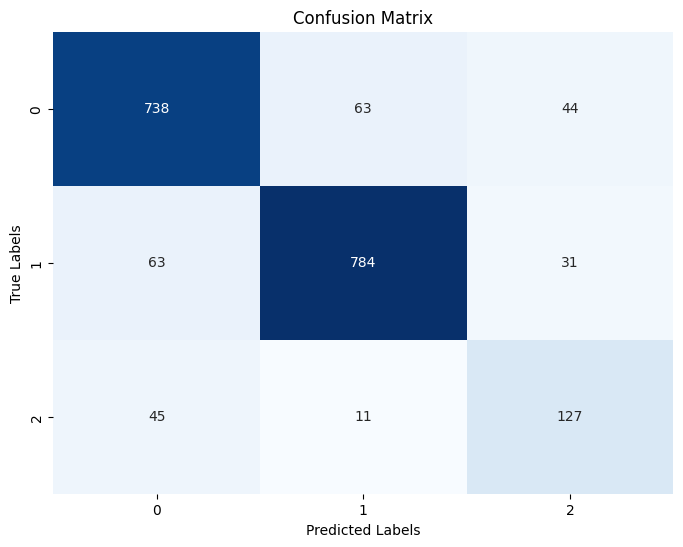

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,f1_score
true_labels = []
predicted_labels = []
with open('/home/azureuser/cloudfiles/code/Users/srsinha/contract-nli/notebooks/labels.out','r') as f:
    for line in f.readlines():
        #print(line)
        t,p = line[:-1].split(' ')
        true_labels.append(t)
        predicted_labels.append(p)

print(len(true_labels),len(predicted_labels))

cm = confusion_matrix(true_labels, predicted_labels,labels=["NotMentioned", "Entailment", "Contradiction"])
print(cm)

print(f1_score(true_labels,predicted_labels,average=None,labels=["NotMentioned","Contradiction","Entailment"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()